In [1]:
import keras
import numpy as np
import tensorflow_hub as hub

# model
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
MbNetV2 = keras.Sequential([hub.KerasLayer(handle=url, input_shape=(224,224,3), trainable=False)])
MbNetV2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [2]:
%%time

import os

# image
image_url = 'https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-top-images.tar.gz'
data_dir = '/content/'

data_root_orig = keras.utils.get_file('imagenetV2', image_url, cache_dir = data_dir, extract = True)

1245929472/1245927936 [==============================] - 33s 0us/step
CPU times: user 7.1 s, sys: 4.49 s, total: 11.6 s
Wall time: 38.7 s


In [3]:
import pathlib
from glob import glob

data_root = pathlib.Path(glob('/content/datasets/*/')[0])
print(data_root)

/content/datasets/imagenetv2-top-images-format-val


In [4]:
!ls /content/datasets/imagenetv2-top-images-format-val

0    155  211  269  325  382  439  496	552  609  666  722  78	 836  893  95
1    156  212  27   326  383  44   497	553  61   667  723  780  837  894  950
10   157  213  270  327  384  440  498	554  610  668  724  781  838  895  951
100  158  214  271  328  385  441  499	555  611  669  725  782  839  896  952
101  159  215  272  329  386  442  5	556  612  67   726  783  84   897  953
102  16   216  273  33	 387  443  50	557  613  670  727  784  840  898  954
103  160  217  274  330  388  444  500	558  614  671  728  785  841  899  955
104  161  218  275  331  389  445  501	559  615  672  729  786  842  9    956
105  162  219  276  332  39   446  502	56   616  673  73   787  843  90   957
106  163  22   277  333  390  447  503	560  617  674  730  788  844  900  958
107  164  220  278  334  391  448  504	561  618  675  731  789  845  901  959
108  165  221  279  335  392  449  505	562  619  676  732  79	 846  902  96
109  166  222  28   336  393  45   506	563  62   677  733  790  847  903

In [10]:
import pandas as pd

# image Label
url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
DF = pd.read_table(url, header=None)
print(DF.head(3))
label_text = DF.values.reshape(-1)

print(len(label_text), type(label_text), label_text.shape)
print(label_text[:5])

            0
0  background
1       tench
2    goldfish
1001 <class 'numpy.ndarray'> (1001,)
['background' 'tench' 'goldfish' 'great white shark' 'tiger shark']


image_count: 10000


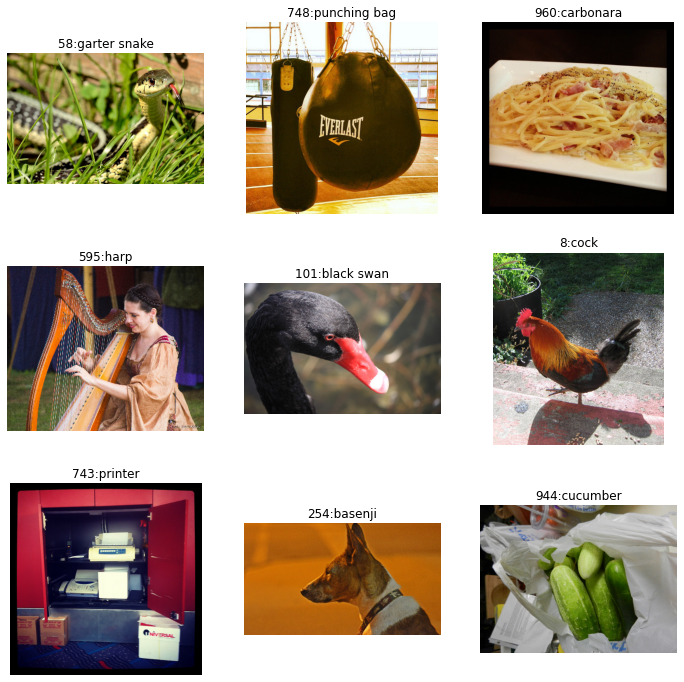

In [21]:
import PIL.Image as Image
import matplotlib.pyplot as plt
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

image_count = len(all_image_paths)
print('image_count:', image_count)

plt.figure(figsize=(12,12))
for n in range(9):
  image_path = random.choice(all_image_paths)  
  plt.subplot(3,3,n+1)
  plt.imshow(plt.imread(image_path))
  idx = int(image_path.split('/')[-2])+1
  plt.title(str(idx)+':'+label_text[idx])
  plt.axis('off')
plt.show()

0 predict값 -0.59450746 1.7132224 -0.06635299 0.099766314 -0.15496582
0 top_5 [895 800 494 496 554]
1 predict값 10.440981 7.350077 6.186475 4.830983 4.1294017
1 top_5 [954 884 739 950 947]
2 predict값 -0.38534373 0.1941416 1.3577 -0.6850239 -0.5866213
2 top_5 [184 207 234 825 182]


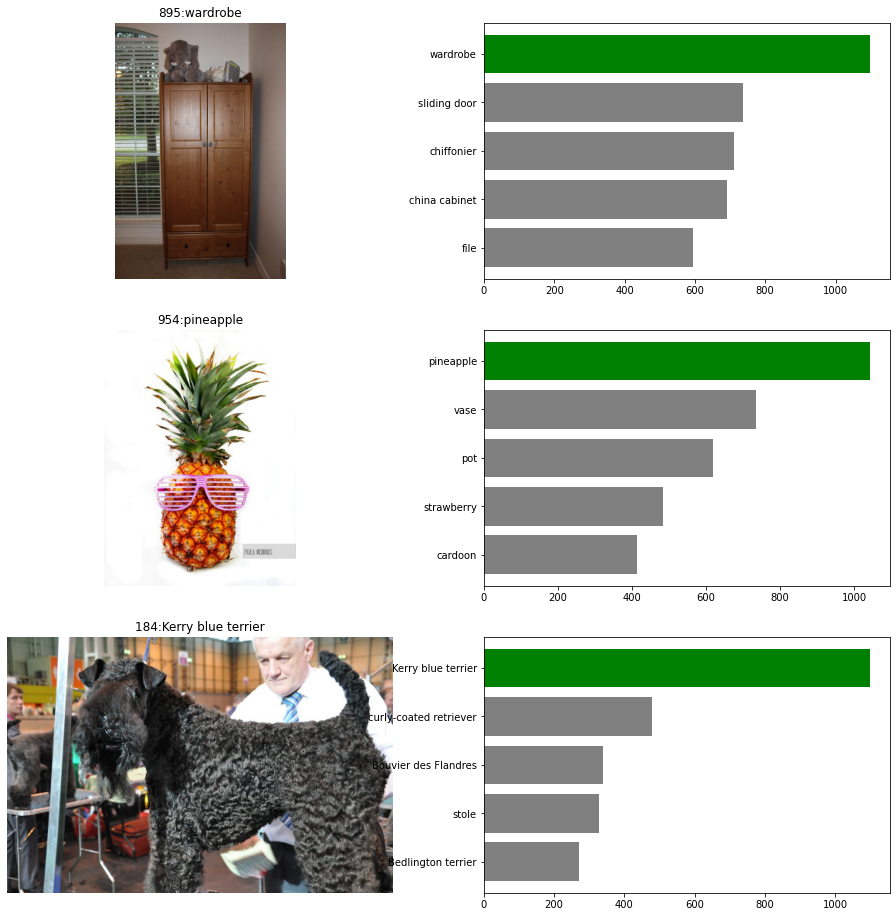

In [40]:
import cv2
plt.figure(figsize=(16,16))

def softmax(x):
  m = np.max(x)
  sm = np.exp(x-m)/np.sum(np.exp(x-m))
  return sm

for n in range(3):
  #image_path = random.choice(all_image_paths)
  image_path = all_image_paths[n*11]
  plt.subplot(3,2,n*2+1)
  plt.imshow(plt.imread(image_path))
  idx = int(image_path.split('/')[-2])+1
  plt.title(str(idx)+':'+label_text[idx])
  plt.axis('off')

  # top_5 그래프
  plt.subplot(3,2,n*2+2)
  img = cv2.imread(image_path)
  img = cv2.resize(img, dsize=(224,224))
  img = img/255.0
  #print(img.shape)
  img = np.expand_dims(img, axis=0)# 왜 축을 늘린거지?
  #print(img.shape) 

  logits = MbNetV2.predict(img)[0]
  #prediction=softmax(logits) # 
  # print(logits)
  print(n,'predict값',logits[954], logits[884], logits[739], logits[950], logits[947])

  top_5_predict = logits.argsort()[::-1][:5]
  print(n,'top_5', top_5_predict)
  labels = [label_text[index] for index in top_5_predict]

  color = ['gray'] *5
  if idx in top_5_predict:
    color[top_5_predict.tolist().index(idx)] = 'green'
  color = color[::-1]

  plt.barh(range(5), logits[top_5_predict][::-1] *100, color=color)
  plt.yticks(range(5), labels[::-1])



[ 0.3729073  -0.54744285  0.00756921 ... -0.0501029  -0.5372828
  0.689019  ]
[895 800 494 496 554]
[ 0.4586629   0.06672619 -0.32443494 ... -0.32457745 -0.0369845
  0.24781309]
[954 884 739 950 947]
[ 0.24536481 -0.28740597  1.0484825  ... -1.4205813   0.21921256
  0.9248512 ]
[184 207 234 825 182]


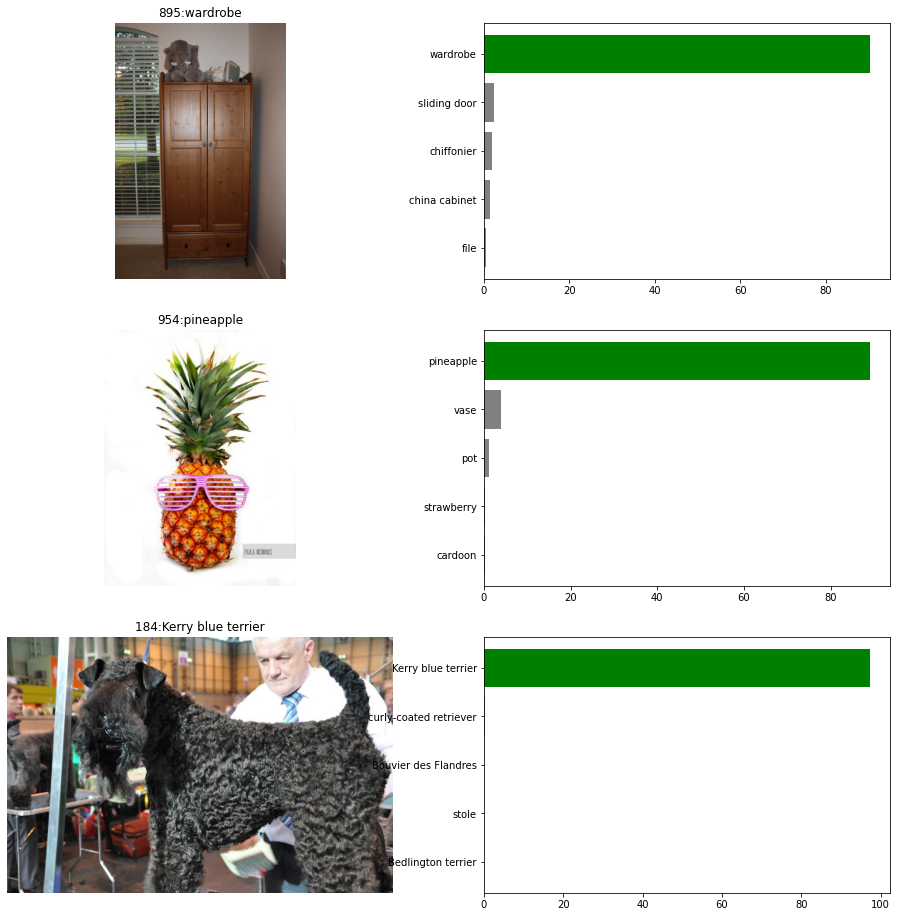

In [41]:
import cv2
plt.figure(figsize=(16,16))

def softmax(x):
  m = np.max(x)
  sm = np.exp(x-m)/np.sum(np.exp(x-m))
  return sm

for n in range(3):
  #image_path = random.choice(all_image_paths)
  image_path = all_image_paths[n*11]
  plt.subplot(3,2,n*2+1)
  plt.imshow(plt.imread(image_path))
  idx = int(image_path.split('/')[-2])+1
  plt.title(str(idx)+':'+label_text[idx])
  plt.axis('off')

  plt.subplot(3,2,n*2+2)
  img = cv2.imread(image_path)
  img = cv2.resize(img, dsize=(224,224))
  img = img/255.0
  #print(img.shape)
  img = np.expand_dims(img, axis=0)# 왜 축을 늘린거지?
  #print(img.shape) 

  logits = MbNetV2.predict(img)[0]
  prediction=softmax(logits) # 
  print(logits)

  top_5_predict = prediction.argsort()[::-1][:5]
  print(top_5_predict)
  labels = [label_text[index] for index in top_5_predict]

  color = ['gray'] *5
  if idx in top_5_predict:
    color[top_5_predict.tolist().index(idx)] = 'green'
  color = color[::-1]

  plt.barh(range(5), prediction[top_5_predict][::-1] *100, color=color)
  plt.yticks(range(5), labels[::-1])

